# Localization with a known map  - Tutorial: Part 2

Localization with a known map, where the map is given as family of line segments. Moreover we optionally allow the environment to be clutterd with additional boxes, which are not mapped. We refer to such a map as _idealized_.

Todo:
- map in localization model could be model random choice as well and we just fix that so we really have the same model for slam and for localization.

In [1]:
# This is a fix for vscode, because it doesn't like my
# julia docstrings for whatever reason, and throws a `Katex` error.
using Markdown
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [2]:
function sortperm_them!(vals, vecs...)
    perm = sortperm(vals)
    id   = 1:length(vals)
    for v in [vals, vecs...]
        v[id] = v[perm]
    end
end

sortperm_them! (generic function with 1 method)

In [3]:
include("src/localization_part_1.jl")
include("src/localization_part_2.jl")

Loading `../data/data_4.jld2` ...

	_segs      Vector{Segment}
	_boxes     Vector{Segment}
	_center    Vector{Float64}
	_xs        Vector{Vector{Float64}}
	_hds       Vector{Float64}
	_ps        Vector{Pose}
	_dxs       Vector{Vector{Float64}}
	_dhds      Vector{Float64}
	_us        Vector{Control}
	_T         Int64
_segs_   CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}
_boxes_  CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}
_ps_     CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}
_as_     CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}

_fov     Float64
_as      Vector{Float64}
_zs      Vector{Vector{Float64}}
_ys      Vector{Vector{Vector{Float64}}}


plot_slam_trace! (generic function with 1 method)

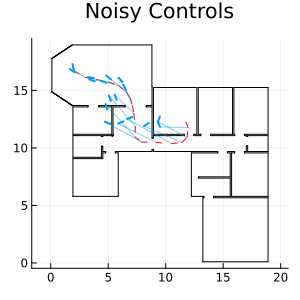

In [4]:
x_noise  = 0.5
hd_noise = 5/360*2π
us_noisy = perturb.(_us, x_noise, hd_noise);

rel_ps = [p+u for (p,u) in zip(_ps[1:end-1],us_noisy)];
ps = [_ps[1]]
for u in us_noisy
    push!(ps, ps[end] + u)
end
# ---------------------
myplot = plot(size=(300,300), 
    title="Noisy Controls",
    aspect_ratio=1., legend=nothing)
plot!(_segs, c=:black)
plot!(_ps[1], c=:red)
plot!(_ps, c=:red)
for (p,q) in zip(_ps[2:end],ps)
    plot!(q, c=col[1], linewidth=2)
    plot!([p.x,q.x], c=col[1], alpha=0.5)
end
myplot

In [5]:
#nbx
function get_offset(v0, k, r)
    center = (r + k.*r)/2
    return v0 - center
end


function first_grid_vec(v0::Vector{Real}, k::Vector{Int}, r::Vector{Real})
    return r + get_offset(v0, k, r) 
end

"""
    vs, ls = vector_grid(v0, k, r)

Returns grid of vectors and their linear indices, given 
a grid center, numnber of grid points along each dimension and
the resolution along each dimension.
"""
function vector_grid(v0::Vector{Float64}, k::Vector{Int}, r::Vector{Float64})
    # Todo: Does it make sense to get a CUDA version of this?
    offset = get_offset(v0, k, r)
    
    shape = Tuple(k)
    cs = CartesianIndices(shape)
    ls = LinearIndices(shape)
    vs = map(I -> [Tuple(I)...].*r + offset, cs);
    return (vs=vs, linear_indices=ls)
end

grid_index(x, v0, k, r) = quantize(x, r, zero=get_offset(v0, k, r));

In [6]:
#nbx
"""
    log_ps, ps = eval_pose_vectors(
                    ps_::CuArray,
                    x::Matrix, 
                    ys_::CuArray, as_::CuArray, w::Int, 
                    s_noise::Float64, outlier::Float64, 
                    outlier_vol::Float64=1.0, zmax::Float64=100.0; sorted=false)

Evaluates a collection of poses 
with respect to different Gaussian mixtures...
"""
function eval_pose_vectors(
            vs::Array{Vector{Float64}},
            x::Vector{Vector{Float64}}, 
            segs, as, w::Int, 
            s_noise::Float64, outlier::Float64, outlier_vol::Float64=1.0, 
            zmax::Float64=100.0; sorted=false)
    
    # Compute sensor measurements and 
    # Gaussian mixture components
    # p_  = CuArray(Vector(p))
    # ps_ = reshape(p_, 1, 3)

    ps_ = CuArray(stack(vs[:]))
    x_  = CuArray(stack(x))
    segs_ = CuArray(stack(Vector.(segs)))
    as_ = CuArray(as)

    zs_       = cast_cu(ps_, segs_; fov=_fov, zmax=zmax)
    ys_tilde_ = get_ys_tilde_cu(zs_, as_, w)
        
    # Evaluate the the observations with respect to the 
    # different Gaussian mixtures computed above
    log_ps_, = sensor_logpdf(x_, ys_tilde_, s_noise, outlier, outlier_vol; return_pointwise=false);
    
    # Move everyting back to CPU
    ps     = Vector.(eachrow(Array(ps_)))
    log_ps = Array(log_ps_)

    # Sort by log prob
    # and return 
    if sorted
        perm   = sortperm(log_ps)
        log_ps = log_ps[perm]
        ps     = ps[perm]
    end
    
    return log_ps, ps
end;



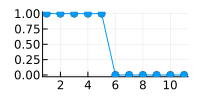

In [7]:
plot(exp.(-750:1:-740) .== 0.0, marker=:o,legend=nothing, size=(200,100))

In [8]:
function exp_normalize(x)
    b = maximum(x)
    y = exp.(x .- b)
    return y / sum(y)
end

exp_normalize (generic function with 1 method)

-2390.8817958284967
135.67036751616223
5.5960234160387435e-12
0.5254799511922192


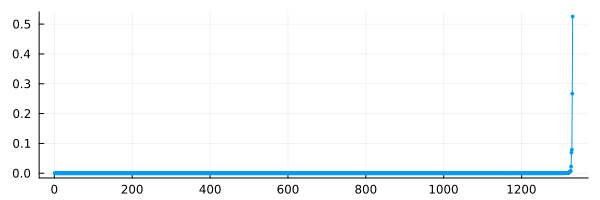

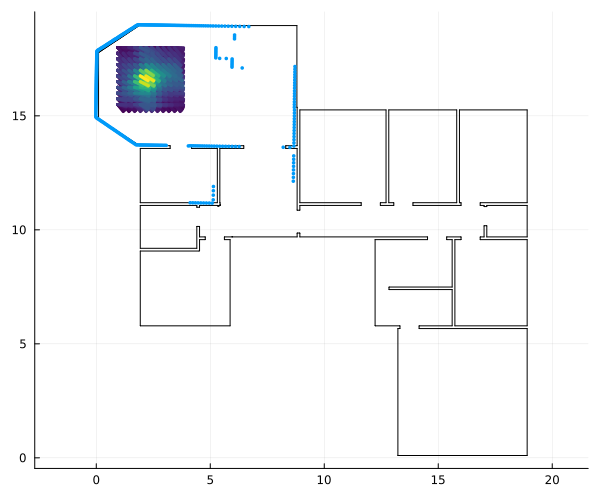

In [194]:
t = 2

ũ  = control_prior_model(0.25, 5/180*π)
p0 = _ps[t] + ũ
v0 = Vector(p0)
k = [11,11,11]
r = [0.25,0.25,5/180*π]
grid_args = (v0, k, r)

vs, = vector_grid(grid_args...)
ps  = stack(vs[:])
x   = _ys[t]


ps_ = CuArray(stack(vs[:]))
x_  = CuArray(stack(x))

as_ = CuArray(_as)

w           = 10
s_noise     = 0.1
outlier     = 1e-1
outlier_vol = 1e2
zmax        = 100.0
sensor_args = (w, s_noise, outlier, outlier_vol, zmax)

log_ps, ps = eval_pose_vectors(vs, x, _segs, _as, sensor_args...; sorted=true);
ps = Pose.(ps)

tau = 100.0
println(minimum(log_ps))
println(maximum(log_ps))

log_ps_tau = log_ps ./ tau

vals = exp_normalize(log_ps_tau)
println(minimum(vals))
println(maximum(vals))  

# ells = log_ps .- maximum(log_ps)
# vals = exp.(ells .- logsumexp(ells))
# probs  = exp.(log_ps .- logsumexp(log_ps))
# probs2 = softmax(log_ps)

# println(logsumexp(log_ps))
# println(maximum(exp.(log_ps .- logsumexp(log_ps) )))
# println(maximum(probs))
# println(maximum(exp.(log_ps)/sum(exp.(log_ps))))
# println(maximum(softmax(log_ps)))

# -----------------------------
mypl = plot(vals, size=(600,200), marker=:o, markerstrokewidth=0, markersize=2, label=nothing)
display(mypl)
# -----------------------------
mypl = plot(size=(600,500), legend=nothing, aspect_ratio=:equal)
plot!(_segs, c=:black)
cs = cgrad(:viridis)[peak_to_peak(log_ps_tau)]
plot!(ps, cs; r=.4, linewidth=3)
scatter!(x .* ps[end], markerstrokewidth=0, c=col[1], markersize=2)
# plot!(_ps[t],c=:red, linewidth=3)
display(mypl)

In [11]:
@gen function grid_proposal(p0::Pose, 
    obs_vector,
    grid_args, 
    sensor_args, 
    tau = 100.0)

    # 
    # Create pose vector grid
    # around previous pose
    # 
    v0 = Vector(p0)
    k = [11,11,11]
    r = [0.25,0.25,5/180*π]
    grid_args = (v0, grid_args...)
    vs, ls = vector_grid(grid_args...)

    
    
    log_ps, ps = eval_pose_vectors(vs, obs_vector, _segs, _as, sensor_args...; sorted=false);    
    log_ps_tau = log_ps ./ tau
    
    probs = exp_normalize(log_ps_tau)
    j ~ categorical(probs)
    x′  = {:x}  ~ mvuniform(vs[j][1:2] - r[1:2]/2, vs[j][1:2] + r[1:2]/2)
    hd′ = {:hd} ~   uniform(vs[j][3]   -   r[3]/2,   vs[j][3]   + r[3]/2)

    return Pose(x′, hd′), (j, vs, ls, log_ps)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Pose, Any, Any, Any, Any], true, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, Some(100.0)], var"##grid_proposal#831", Bool[0, 0, 0, 0, 0], false)

│
├── :pose
│   │
│   ├── :hd : -1.292108381013924
│   │
│   └── :x : [2.0485613132820677, 17.18810927346954]
│
├── :sensor
│   │
│   └── :x : [[-1.4843593954678596, -1.8178159824440144e-16], [-1.4765892101730171, -0.025773960535875426], [-1.468975381371807, -0.05129775068193733], [-1.4559175962554882, -0.07630140803885349], [-1.4461711780831326, -0.10112614000794444], [-1.4390269644426426, -0.12589854589685417], [-1.4319848033740672, -0.1505076676707018], [-1.4172888522924383, -0.17402118940130873], [-1.4104955012751026, -0.1982322150931714], [-1.4037696334152552, -0.22233526773305484], [-1.3923367481206819, -0.24550653492556224], [-1.3830447941407475, -0.26883667463639094], [-1.3765363586926445, -0.29259183541748074], [-1.3674860500394814, -0.31570903076205664], [-1.3563800848380632, -0.33818353764893827], [-1.3500010319723665, -0.36173168629817826], [-1.3424087327225875, -0.38492950991053093], [-1.3302378065182472, -0.40669451108889776], [-1.3239080417585753, -0.4301637987684983], [

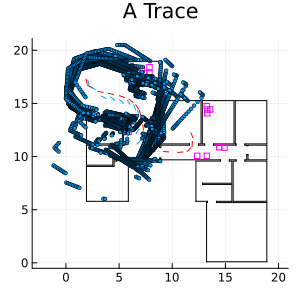

In [195]:
idealized = true
the_map   = idealized ? _segs : vcat(_segs, _boxes);

p0        = _ps[1]
x0_noise  = .2
hd0_noise = 10/360*2π

x_noise  = 0.2
hd_noise = 15/360*2π

sensor_args = (
    w           = 10,
    s_noise     = 0.1,
    outlier     = 1e-6,
    outlier_vol = 1e2,
    zmax        = 100.0,
)

args = (
    the_map,                           # Map
    _us,                          # Controls
    p0, x0_noise, hd0_noise,           # Pose prior model
    x_noise, hd_noise,                 # Motion model
    sensor_args...   # Sensor model
);

T = 10

ch = choicemap()
for t_chain=0:T
    ch[add_addr_prefix(t_chain,:sensor => :x)] = _ys[t_chain+1]
end


tr, = generate(static_slam_model, (T, args...), ch)
display(get_choices(tr))

plot_slam_trace!(tr)

In [205]:
#nbx
@gen function grid_proposal(tr::Gen.Trace, 
    t_chain::Int, 
    obs_vector,
    grid_args, 
    sensor_args, 
    tau)

    t = t_chain + 1
    # 
    # Create pose vector grid
    # around previous pose
    # 
    p0 = get_pose(tr, t)
    v0 = Vector(p0)
    vs, ls = vector_grid(v0, grid_args...)


    log_ps, ps = eval_pose_vectors(vs, obs_vector, _segs, _as, sensor_args...; sorted=false);    
    log_ps_tau = log_ps ./ tau
    
    probs = exp_normalize(log_ps_tau)
    j ~ categorical(probs)
    x′  = {:x}  ~ mvuniform(vs[j][1:2] -  grid_args.r[1:2]/2, vs[j][1:2] + grid_args.r[1:2]/2)
    hd′ = {:hd} ~   uniform(vs[j][3]   -  grid_args.r[3]/2,   vs[j][3]   + grid_args.r[3]/2)

    return Pose(x′, hd′), (j, vs, ls, log_ps)
end

@transform involution (tr, aux) to (tr′, aux′) begin
    _,t_chain, = get_args(aux)

    x  = @read(aux[:x], :continuous)
    hd = @read(aux[:hd], :continuous)

    @write(tr′[add_addr_prefix(t_chain,:pose => :x)],   x, :continuous)
    @write(tr′[add_addr_prefix(t_chain,:pose => :hd)], hd, :continuous)

end

@transform grid_tr_transform (tr_grid) to (tr_slam) begin
    _,t, = get_args(tr_grid)

    x  = @read(tr_grid[:x], :continuous)
    hd = @read(tr_grid[:hd], :continuous)

    @write(tr_slam[add_addr_prefix(t-1,:pose => :x)],   x, :continuous)
    @write(tr_slam[add_addr_prefix(t-1,:pose => :hd)], hd, :continuous)

end

TraceTransformDSLProgram(var"#447###grid_tr_transform_fn!#1336", nothing)

  0.216907 seconds (96.70 k allocations: 10.380 MiB, 32.07% gc time)
  0.188257 seconds (95.27 k allocations: 10.255 MiB, 22.43% gc time)
  0.185868 seconds (93.60 k allocations: 10.113 MiB, 21.87% gc time)
  0.185790 seconds (91.94 k allocations: 9.972 MiB, 22.36% gc time)
  0.185378 seconds (90.28 k allocations: 9.830 MiB, 22.42% gc time)
4
  0.184371 seconds (88.62 k allocations: 9.689 MiB, 22.83% gc time)
  0.182999 seconds (86.96 k allocations: 9.547 MiB, 22.40% gc time)
  0.183726 seconds (85.29 k allocations: 9.406 MiB, 22.68% gc time)
  0.180141 seconds (83.63 k allocations: 9.264 MiB, 22.30% gc time)
  0.180598 seconds (81.97 k allocations: 9.123 MiB, 22.48% gc time)
  0.177036 seconds (80.31 k allocations: 8.981 MiB, 22.05% gc time)


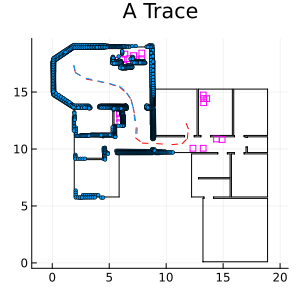

In [278]:
# add_addr_prefix
x = obs_vector = _ys[1]

grid_args = (
    k = [21,21,21],
    r = [0.05, 0.05, 1/180*π]
)
sensor_args = (
    w           = 20,
    s_noise     = .1,
    outlier     = 1e-2,
    outlier_vol = 1e2,
    zmax        = 100.0,
)
tau = 100.

# tr′ = tr
# ws = [project.([tr], [select(add_addr_prefix(t,:sensor => :x)) for t=0:T])]

# display(plot_slam_trace!(tr))
for t_chain=0:T
    obs_vector = _ys[t_chain+1]
    @time tr′, acc = Gen.mh(tr′, grid_proposal, (t_chain, obs_vector, grid_args, sensor_args, tau), involution)
    if acc
        println(t_chain)
    end
    # display(plot_slam_trace!(tr′))
end
push!(ws, project.([tr′], [select(add_addr_prefix(t,:sensor => :x)) for t=0:T]))

display(plot_slam_trace!(tr′))


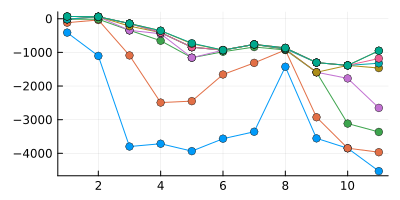

In [279]:
mypl = plot(size=(400,200), legend=nothing)
for w in ws
    plot!(w, marker=:o)
end
display(mypl)


In [ ]:
# add_addr_prefix
x = obs_vector = _ys[1]

grid_args = (
    k = [9,9,9],
    r = [0.1, 0.1, 2/180*π]
)
sensor_args = (
    w           = 10,
    s_noise     = 0.1,
    outlier     = 1e-6,
    outlier_vol = 1e2,
    zmax        = 100.0,
)
tau = 1.00

tr′  = simulate(grid_proposal, (tr, 2, obs_vector, grid_args, sensor_args, tau))
_, (j, vs, ls, log_ps) = tr′[]

LoadError: BoundsError: attempt to access 2-element Vector{Any} at index [3]

In [219]:
# add_addr_prefix
x = obs_vector = _ys[1]

grid_args = (
    k = [9,9,9],
    r = [0.1, 0.1, 2/180*π]
)
sensor_args = (
    w           = 10,
    s_noise     = 0.1,
    outlier     = 1e-6,
    outlier_vol = 1e2,
    zmax        = 100.0,
)
tau = 100.00

tr′    = simulate(grid_proposal, (tr, 2, obs_vector, grid_args, sensor_args, tau))
transl = DeterministicTraceTranslator(static_slam_model, (T, args...), choicemap(), grid_tr_transform)
tr′′, dw = transl(tr′)
# score_plus = get_score(tr′′)

# tr_new, w_update,_, ch_old = Gen.update(tr, get_choices(tr′′))
# display(get_choices(tr′′))
# display(ch_old)
# w, re = assess(grid_proposal, (tr, 2, obs_vector, grid_args, sensor_args, tau), choicmap(:x => :hd => ))

# _, (j, vs, ls, log_ps) = tr′[]

# # (backward_score, backward_retval) =
#         # assess(translator.q, (new_model_trace, translator.q_args...), backward_choices)

# display(get_choices(tr)[:chain => 1 => :pose => :x])
# display(get_choices(tr′)[:x])
# display(get_choices(tr′′)[add_addr_prefix(1, :pose => :x)])
# dw, get_score(tr′), get_score(tr′′), get_score(tr), -log(prod(grid_args.r))
display(get_choices(tr′′)[add_addr_prefix(0, :pose => :x)])

LoadError: choices1 has leaf node at hd and choices2 has leaf node at hd

In [189]:
logpdf(mvuniform, [0.5;0.5], [0.0;0.0], [2.0;2.0]), -log(4)

(-1.3862943611198906, -1.3862943611198906)

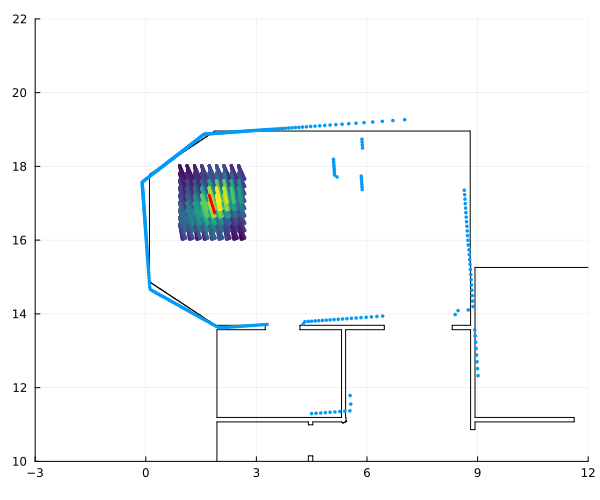

In [164]:

x = obs_vector = _ys[1]

grid_args = (
    k = [9,9,9],
    r = [0.2,0.2,2/180*π]
)
sensor_args = (
    w           = 10,
    s_noise     = 0.1,
    outlier     = 1e-1,
    outlier_vol = 1e2,
    zmax        = 100.0,
)

p = get_pose(tr, 1)

q, (j, vs, ls, log_ps) = grid_proposal(tr, 1, obs_vector, grid_args, sensor_args)


ps = Pose.(vs[:])
cs = cgrad(:viridis)[peak_to_peak(log_ps)]

sortperm_them!(log_ps, cs, ps)

# -----------------------------
mypl = plot(size=(600,500), legend=nothing, aspect_ratio=:equal, xlim=(-3,12),ylim=(10,22))
plot!(_segs, c=:black)
plot!(ps, cs; r=.4, linewidth=3)
scatter!(x .* p, markerstrokewidth=0, c=col[1], markersize=2)
plot!(p,c=:red, linewidth=3)
display(mypl)

In [ ]:
    forward_trace = simulate(translator.q, (prev_model_trace, translator.q_args...,))
    forward_score = get_score(forward_trace)
    forward_choices = get_choices(forward_trace)
    forward_retval = get_retval(forward_trace)

    (new_model_trace, backward_choices, log_weight) = translator.involution(
        prev_model_trace, forward_choices, forward_retval, translator.q_args)
    
        (backward_score, backward_retval) = assess(translator.q, (new_model_trace, translator.q_args...), backward_choices)

    log_weight + (backward_score - forward_score)

In [ ]:
function metropolis_hastings(
    trace, 
    proposal::GenerativeFunction,
    proposal_args::Tuple, 
    involution::Union{TraceTransformDSLProgram,Function};
    check=false, 
    observations=EmptyChoiceMap())
        
    
    trace_translator = SymmetricTraceTranslator(proposal, proposal_args, involution)
    (new_trace, log_weight) = trace_translator(trace; check=check, observations=observations)
    
    if log(rand()) < log_weight
        # accept
        (new_trace, true)
    else
        # reject
        (trace, false)
    end
end

In [ ]:
translator = GeneralTraceTranslator(
    p_new=p2,
    p_new_args=(),
    new_observations=choicemap(),
    q_forward=q1,
    q_forward_args=(),
    q_backward=q2,
    q_backward_args=(),
    f=f)

In [ ]:
# (new_trace, accepted) = mh(trace, proposal::GenerativeFunction, proposal_args::Tuple, involution; ..)


Gen.mh(tr, )